In [1]:
from warnings import filterwarnings as f
f("ignore")

In [2]:
# import libraries 
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

In [3]:
# define global stopwords
list_stopwords = set(stopwords.words('indonesian'))

In [4]:
# load dataset
data = pd.read_csv("ds.csv")

# overview dataset
data.head()

,id,created_at,text,label
0,1537498780144010000,17/06/22 01.14,@sahabatgiselle Pesen shopeefood yang makanan ...,positif
1,1537498557913400000,17/06/22 01.13,@holyzaa @FOODFESS2 pake shopeefood aja 24k bi...,positif
2,1537495458813480000,17/06/22 01.00,Indo\n\nPesawat siapin budget : 1 - 1.5jt pp\n...,netral
3,1537480425895240000,17/06/22 00.01,yaampun dapet driver shopee food baik bangettt...,positif
4,1537478559547390000,16/06/22 23.53,@ShopeePay_ID Mana miiinn???? Aku mau jajan di...,netral


# 1. Exploratory Data Analysis

In [5]:
# extract date from created_at feature
data["date"] = data["created_at"].apply(lambda x: x.split("/")[0]).astype(int)

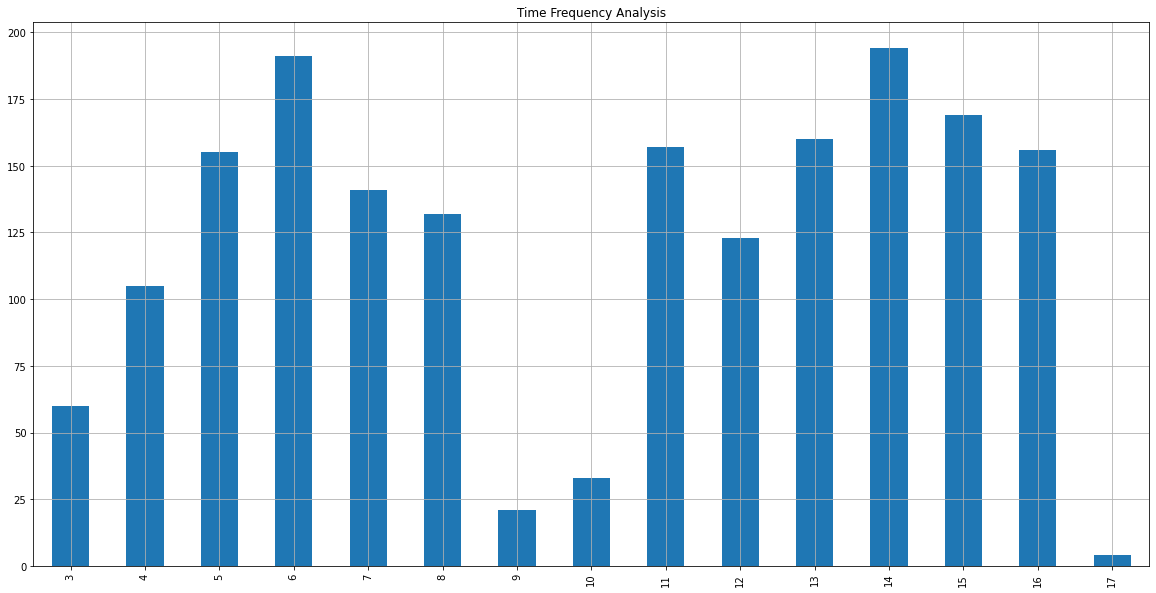

In [6]:
# overview time analysis
data["date"].value_counts().sort_index().plot(kind = "bar", figsize = (20, 10)).set_title("Time Frequency Analysis")
plt.grid(True);

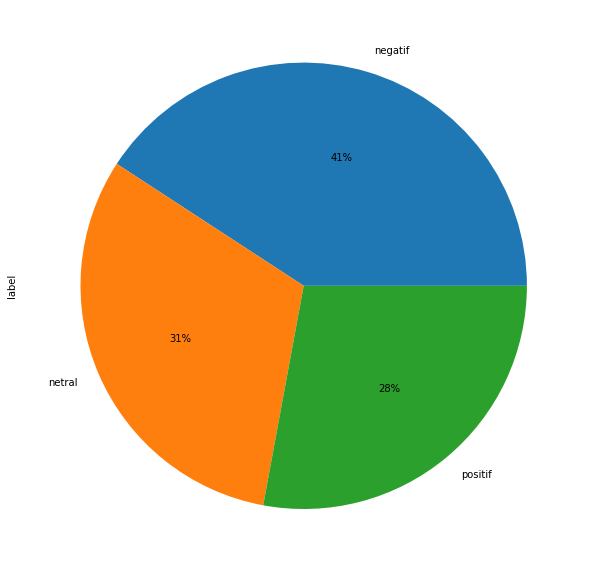

In [7]:
# overview sentiment
data["label"].value_counts().plot(kind = "pie", autopct = "%2.f%%", figsize = (10, 15));

In [8]:
def generate_wordcloud(data, title):
    comment_words = ''
    for comment in data["text"]:
        # apply tokenize and lowercase
        comment_words += " ".join([i.lower() for i in comment.split()]) + " "
        
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = list_stopwords,
                min_font_size = 10).generate(comment_words)
 
    # plot the wordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [9]:
data["label"].unique()

array(['positif', 'netral', nan, 'negatif'], dtype=object)

In [10]:
# separate data based on their label
pos = data[data["label"] == "positif"]
neu = data[data["label"] == "netral"]
neg = data[data["label"] == "negatif"]

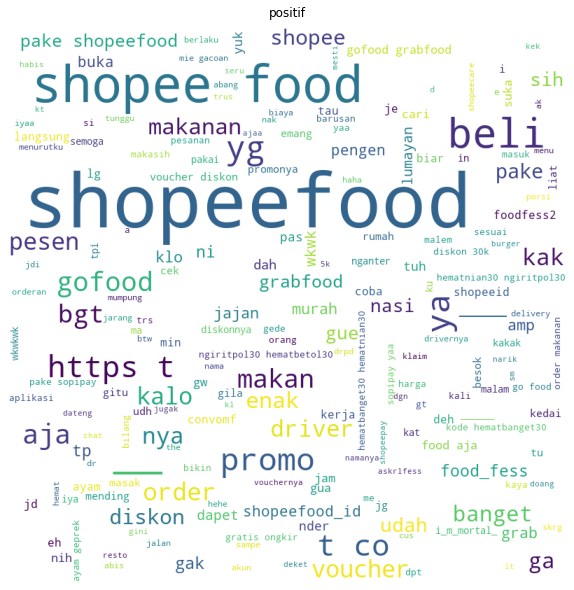

In [11]:
generate_wordcloud(pos, "positif")

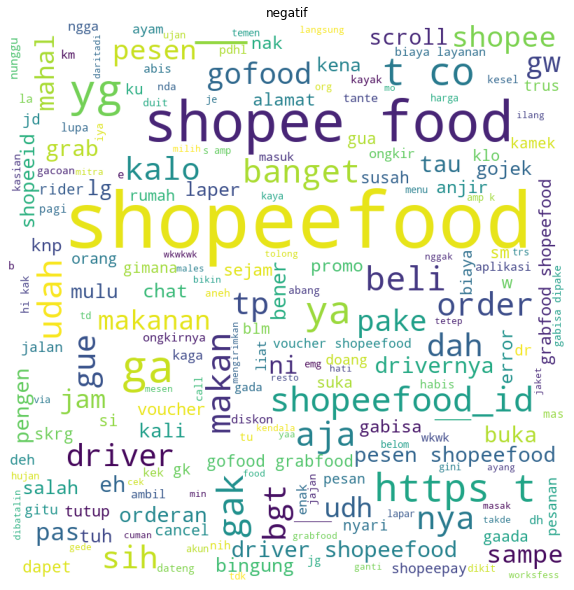

In [12]:
generate_wordcloud(neg, "negatif")

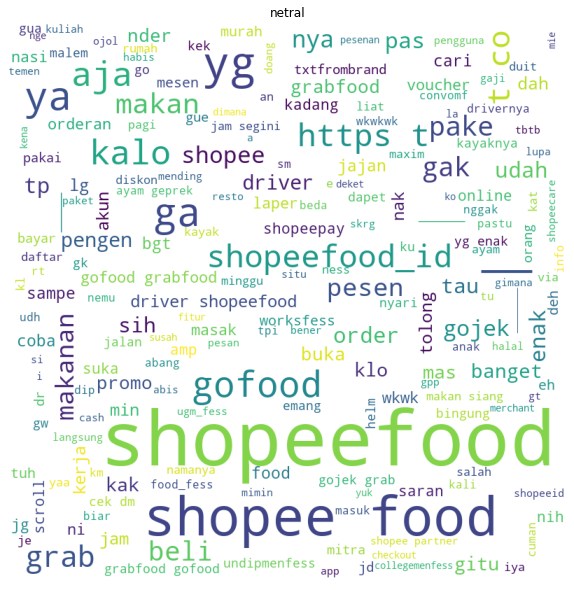

In [13]:
generate_wordcloud(neu, "netral")

# 2. Text Preprocessing

In [14]:
# !pip install sastrawi

In [15]:
# load libraries
import re
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [16]:
stemmer  = StemmerFactory().create_stemmer()
stopword = set(stopwords.words('indonesian'))

In [17]:
# define cleaning function
def cleansing(text):
    # senang emoticon
    emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', ':d', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
    # sedih emoticon
    emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
    # menghapus emoticon
    emoticons = emoticons_happy.union(emoticons_sad)
    text = ' '.join([word for word in text.split() if word not in emoticons])
    # hapus mentions
    text = re.sub('@[^\s]+','',text)
    # hapus hashtags
    text = re.sub("#[A-Za-z0-9_]+","", text)
    # hapus url / links
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    # hapus tanda baca
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    # hapus multiple spaces
    text = re.sub('\s+', ' ', text)
    # hapus retweets
    text = re.sub(r'RT', '', text)
    # hapus angka
    text = re.sub(r'[0-9]+', ' ', text)
    # hapus huruf terkait shopee dan kecilkan huruf
    text = " ".join([i.lower() for i in text.split() if i.lower().strip() not in ["shopee", "shopeefood", "shopeefod_id", "food"]])

    return text

def casefolding(text):
    # mengubah karakter menjadi huruf kecil
    text = text.lower()
    return text

def tokenizing(text):
    text = text.split()
    return text

def remove_stopword(text):
    stp = stopwords.words('indonesian')
    text = ' '.join([word for word in text if word not in stp])
    return text

def stem_text(texts):
    result = []
    for text in tqdm(texts):
        result.append(' '.join([stemmer.stem(word) for word in text.split()]))
    return result

In [18]:
# select feature of dataset
df = data[['text', 'label']]

df.head()

,text,label
0,@sahabatgiselle Pesen shopeefood yang makanan ...,positif
1,@holyzaa @FOODFESS2 pake shopeefood aja 24k bi...,positif
2,Indo\n\nPesawat siapin budget : 1 - 1.5jt pp\n...,netral
3,yaampun dapet driver shopee food baik bangettt...,positif
4,@ShopeePay_ID Mana miiinn???? Aku mau jajan di...,netral


In [19]:
# apply text cleaning

# proses cleansing
df['cleansing'] = df['text'].apply(lambda x: cleansing(x))
print("Cleaning Done...")

# proses casefolding
df['casefolding'] = df['cleansing'].apply(lambda x: casefolding(x))
print("Casefolding Done...")

# proses tokenizing
df['tokenizing'] = df['casefolding'].apply(lambda x: tokenizing(x))
print("Tokenizing Done...")

# proses hapus stopword
df['stopword'] = df['tokenizing'].apply(lambda x: remove_stopword(x))
print("Stopwords Done...")

df.head()

Cleaning Done...
Casefolding Done...
Tokenizing Done...
Stopwords Done...


,text,label,cleansing,casefolding,tokenizing,stopword
0,@sahabatgiselle Pesen shopeefood yang makanan ...,positif,pesen yang makanan jam gt kalau gaakkkk,pesen yang makanan jam gt kalau gaakkkk,"[pesen, yang, makanan, jam, gt, kalau, gaakkkk]",pesen makanan jam gt gaakkkk
1,@holyzaa @FOODFESS2 pake shopeefood aja 24k bi...,positif,pake aja k bisa double lauk utama lauk tambaha...,pake aja k bisa double lauk utama lauk tambaha...,"[pake, aja, k, bisa, double, lauk, utama, lauk...",pake aja k double lauk utama lauk tambahan
2,Indo\n\nPesawat siapin budget : 1 - 1.5jt pp\n...,netral,indo pesawat siapin budget jt pp kereta k pp t...,indo pesawat siapin budget jt pp kereta k pp t...,"[indo, pesawat, siapin, budget, jt, pp, kereta...",indo pesawat siapin budget jt pp kereta k pp t...
3,yaampun dapet driver shopee food baik bangettt...,positif,yaampun dapet driver baik bangettt huhuhu seha...,yaampun dapet driver baik bangettt huhuhu seha...,"[yaampun, dapet, driver, baik, bangettt, huhuh...",yaampun dapet driver bangettt huhuhu sehat bap...
4,@ShopeePay_ID Mana miiinn???? Aku mau jajan di...,netral,mana miiinn aku mau jajan di nii huhu,mana miiinn aku mau jajan di nii huhu,"[mana, miiinn, aku, mau, jajan, di, nii, huhu]",miiinn jajan nii huhu


In [20]:
# proses stemming
df['stem'] = stem_text(df['stopword'].tolist())
print("Stem Done...")

100%|█████████████████████████████████████| 1801/1801 [00:01<00:00, 1583.29it/s]

Stem Done...


In [27]:
# overview result after text cleaning
df.head()

,text,label,cleansing,casefolding,tokenizing,stopword,stem
0,@sahabatgiselle Pesen shopeefood yang makanan ...,positif,pesen yang makanan jam gt kalau gaakkkk,pesen yang makanan jam gt kalau gaakkkk,"[pesen, yang, makanan, jam, gt, kalau, gaakkkk]",pesen makanan jam gt gaakkkk,sen makan jam gt gaakkkk
1,@holyzaa @FOODFESS2 pake shopeefood aja 24k bi...,positif,pake aja k bisa double lauk utama lauk tambaha...,pake aja k bisa double lauk utama lauk tambaha...,"[pake, aja, k, bisa, double, lauk, utama, lauk...",pake aja k double lauk utama lauk tambahan,pake aja k double lauk utama lauk tambah
2,Indo\n\nPesawat siapin budget : 1 - 1.5jt pp\n...,netral,indo pesawat siapin budget jt pp kereta k pp t...,indo pesawat siapin budget jt pp kereta k pp t...,"[indo, pesawat, siapin, budget, jt, pp, kereta...",indo pesawat siapin budget jt pp kereta k pp t...,indo pesawat siapin budget jt pp kereta k pp t...
3,yaampun dapet driver shopee food baik bangettt...,positif,yaampun dapet driver baik bangettt huhuhu seha...,yaampun dapet driver baik bangettt huhuhu seha...,"[yaampun, dapet, driver, baik, bangettt, huhuh...",yaampun dapet driver bangettt huhuhu sehat bap...,yaampun dapet driver bangettt huhuhu sehat bap...
4,@ShopeePay_ID Mana miiinn???? Aku mau jajan di...,netral,mana miiinn aku mau jajan di nii huhu,mana miiinn aku mau jajan di nii huhu,"[mana, miiinn, aku, mau, jajan, di, nii, huhu]",miiinn jajan nii huhu,miiinn jajan nii huhu


In [34]:
# filter data
dataset = df[['stem', 'label']]
dataset = dataset.dropna().reset_index().drop("index", axis = 1)
dataset.head()

,stem,label
0,sen makan jam gt gaakkkk,positif
1,pake aja k double lauk utama lauk tambah,positif
2,indo pesawat siapin budget jt pp kereta k pp t...,netral
3,yaampun dapet driver bangettt huhuhu sehat bap...,positif
4,miiinn jajan nii huhu,netral


# 3. Data Preprocessing

In [35]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [36]:
def train_test_split(X, y, test_size):
    arr_rand = np.random.rand(X.shape[0])
    size     = test_size * 10
    split    = arr_rand < np.percentile(arr_rand, test_size)
    
    X_train = X[~split]
    y_train = y[~split]
    X_test  = X[~split]
    y_test  = y[~split]
    
    return X_train, y_train, X_test, y_test

In [37]:
# convert text to numerical
label = LabelEncoder()
Y     = label.fit_transform(dataset["label"].values.reshape(-1, 1))
print(Y)

[2 2 1 ... 1 0 1]


In [38]:
# weighting text using TF-IDF
vectorizer = TfidfVectorizer()
X          = vectorizer.fit_transform(dataset["stem"].values).toarray()
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [106]:
# overview dimension
print(X.shape, Y.shape)

(1799, 4165) (1799,)


# 4. Data Modeling

In [39]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

## 4.1. Multiclass Classification

In [44]:
# split dataset
X_train, y_train, X_test, y_test = train_test_split(X, Y, test_size = 0.2)

In [45]:
model = GaussianNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91       733
           1       0.90      0.86      0.88       562
           2       0.78      1.00      0.88       500

    accuracy                           0.89      1795
   macro avg       0.89      0.90      0.89      1795
weighted avg       0.91      0.89      0.89      1795



In [121]:
model = MultinomialNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84       733
           1       0.94      0.72      0.81       562
           2       0.98      0.71      0.82       500

    accuracy                           0.83      1795
   macro avg       0.88      0.81      0.83      1795
weighted avg       0.86      0.83      0.83      1795



In [113]:
model = BernoulliNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88       733
           1       0.85      0.82      0.84       562
           2       0.98      0.68      0.80       500

    accuracy                           0.85      1795
   macro avg       0.87      0.83      0.84      1795
weighted avg       0.86      0.85      0.84      1795



## 4.2. Binary Classification

In [118]:
binary_dataset = dataset[dataset["label"] != "netral"]

In [119]:
# convert text to numerical
label = LabelEncoder()
Y     = label.fit_transform(binary_dataset["label"].values.reshape(-1, 1))

In [120]:
# weighting text using TF-IDF
vectorizer = TfidfVectorizer()
X          = vectorizer.fit_transform(binary_dataset["stem"].values).toarray()

In [122]:
# overview dimension
print(X.shape, Y.shape)

(1236, 3300) (1236,)


In [123]:
# split dataset
X_train, y_train, X_test, y_test = train_test_split(X, Y, test_size = 0.2)

In [124]:
model = GaussianNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       732
           1       0.88      1.00      0.94       501

    accuracy                           0.95      1233
   macro avg       0.94      0.95      0.95      1233
weighted avg       0.95      0.95      0.95      1233



In [125]:
model = MultinomialNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       732
           1       1.00      0.77      0.87       501

    accuracy                           0.90      1233
   macro avg       0.93      0.88      0.90      1233
weighted avg       0.92      0.90      0.90      1233



In [126]:
model = BernoulliNB().fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       732
           1       0.98      0.83      0.90       501

    accuracy                           0.93      1233
   macro avg       0.94      0.91      0.92      1233
weighted avg       0.93      0.93      0.93      1233



# 5. Text Testing

In [76]:
tweet   = cleansing('mantap pesanan kilat')
tweet   = casefolding(tweet)
tweet   = tokenizing(tweet)
tweet   = remove_stopword(tweet)
tweet   = stem_text(tweet)
v_data  = vectorizer.transform(tweet)

100%|████████████████████████████████████████| 20/20 [00:00<00:00, 38251.75it/s]


In [77]:
v_data

<20x4165 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [78]:
model.predict(v_data)[0]

0

In [75]:
# 0 : negatif
# 1 : netral - in multiclass
# 2 : positif